Image Retrieval Basic Practice


## Instruction
이미지 검색과 관련된 기본적인 요소들을 직접 구현하며, 딥러닝 기반의 이미지 검색 시스템에 대해 이해하는 것을 목표로 합니다. 본 실습은 이미지 검색의 전체적인 파이프라인을 따라, 아래와 같은 순서로 구성되어 있습니다.

## Reference materials
* PyTorch \[[Documentation](https://pytorch.org/docs/stable/index.html)\]
* NumPy  \[[Documentation](https://numpy.org/doc/stable/)\]

아래는 이미지 검색 모델에 활용되는 기본적인 손실\(Loss\) 함수에 대한 이해 및 구현을 도와주는 자료입니다. 실습 진행에 어려움을 겪을 시 활용할 수 있습니다.
* Pytorch-metric-learning \[[Documentation](https://kevinmusgrave.github.io/pytorch-metric-learning/) / [GitHub](https://github.com/KevinMusgrave/pytorch-metric-learning)\]




## Step 1: Set the enviroments
실습 진행을 위한 기본적인 환경 설정을 진행합니다.

### Step 1-1: Import the necessary libraries
이미지 검색 시스템 구축에 활용할 라이브러리를 import합니다.

In [ ]:
# Import libraries to develop the basic image retrieval system
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100 # https://www.cs.toronto.edu/~kriz/cifar.html
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Step 1-2 Construct the dataset for image retireval



In [ ]:
# Download the original datasets
original_train = CIFAR100(root="CIFAR100_Dataset", train=True, transform=None, download=True)
original_val = CIFAR100(root="CIFAR100_Dataset", train=False, transform=None, download=True)


# This will be used to create train and val sets that are class-disjoint
class ClassDisjointCIFAR100(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, transform):
        rule = (lambda x: x < 50) if train else (lambda x: x >= 50)
        train_filtered_idx = [
            i for i, x in enumerate(original_train.targets) if rule(x)
        ]
        val_filtered_idx = [i for i, x in enumerate(original_val.targets) if rule(x)]
        self.data = np.concatenate(
            [
                original_train.data[train_filtered_idx],
                original_val.data[val_filtered_idx],
            ],
            axis=0,
        )
        self.targets = np.concatenate(
            [
                np.array(original_train.targets)[train_filtered_idx],
                np.array(original_val.targets)[val_filtered_idx],
            ],
            axis=0,
        )
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

class ClassDisjointCIFAR100Test(torch.utils.data.Dataset):
    def __init__(self, original_val, train, transform):
        rule = (lambda x: x < 50) if train else (lambda x: x >= 50)
        val_filtered_idx = [i for i, x in enumerate(original_val.targets) if rule(x)]
        self.data = original_val.data[val_filtered_idx]
        self.targets = np.array(original_val.targets)[val_filtered_idx]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

100%|██████████| 169001437/169001437 [00:03<00:00, 47908624.17it/s]


Extracting CIFAR100_Dataset/cifar-100-python.tar.gz to CIFAR100_Dataset
Files already downloaded and verified


아래는 구축한 CIFAR-100 데이터셋에 대하여 이미지 전처리를 적용하고 해당 데이터셋을 불러오는 과정입니다.

In [ ]:
# Set the image transforms
train_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Load class disjoint CIFAR-100 training and validation set
train_dataset = ClassDisjointCIFAR100(original_train, original_val, True, train_transform)
test_dataset = ClassDisjointCIFAR100Test(original_val, False, test_transform)  # We use only the validation dataset for testing because of the computation time

### Step 1-3 Construct the dataloader for training and testing
학습 및 평가에 활용할 데이터를 불러오는 data loader를 생성합니다.



이미지 검색 모델 학습에 활용되는 loss 함수들은, anchor 데이터의 positive / negative pair를 활용합니다. 여기서 postivie pair는 anchor와 같은 클래스를 나타내는 데이터이며, negative pair는 anchor와 다른 클래스를 나타내는 데이터입니다. 아래는 학습에 활용하는 mini-batch에 같은 클래스와 다른 클래스를 골고루 포함할 수 있도록 하는 mini-batch sampler에 해당하는 내용입니다. 해당 MPerClassSampler는 mini-batch 내에서 각 클래스 당 m개의 sample을 포함하도록 합니다.

In [ ]:
import collections
from torch.utils.data.sampler import Sampler


# modified from
# https://raw.githubusercontent.com/bnulihaixia/Deep_metric/master/utils/sampler.py
class MPerClassSampler(Sampler):
    """
    At every iteration, this will return m samples per class. For example,
    if dataloader's batchsize is 100, and m = 5, then 20 classes with 5 samples
    each will be returned
    """

    def __init__(self, labels, m, length_before_new_iter=100000):
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()
        self.m_per_class = int(m) # 4
        self.labels_to_indices = self.get_labels_to_indices(labels)
        self.labels = list(self.labels_to_indices.keys()) # 100
        self.length_of_single_pass = self.m_per_class * len(self.labels) # 400
        self.list_size = length_before_new_iter # 30000

    def get_labels_to_indices(self, labels):
            """
            Creates labels_to_indices, which is a dictionary mapping each label
            to a numpy array of indices that will be used to index into self.dataset
            """
            if torch.is_tensor(labels):
                labels = labels.cpu().numpy()
            labels_to_indices = collections.defaultdict(list)
            for i, label in enumerate(labels):
                labels_to_indices[label].append(i)
            for k, v in labels_to_indices.items():
                labels_to_indices[k] = np.array(v, dtype=int)
            return labels_to_indices


    def __len__(self):
        return self.list_size

    def __iter__(self):
        idx_list = [0] * self.list_size
        i = 0
        num_iters = self.calculate_num_iters()
        for _ in range(num_iters):
            np.random.shuffle(self.labels)
            curr_label_set = self.labels
            for label in curr_label_set:
                t = self.labels_to_indices[label]
                idx_list[i : i + self.m_per_class] = np.random.choice(t, size=self.m_per_class)
                i += self.m_per_class
        return iter(idx_list)

    def calculate_num_iters(self):
        divisor = (
            self.length_of_single_pass
        )
        return self.list_size // divisor

아래는 구현한 sampler 함수를 활용하여, 학습 데이터를 불러오는 training dataset loader에 생성합니다.

In [ ]:
# Create the mini-batch sampler
sampler = MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset)) # 4 samples per each class

# Create the training dataloader
train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        sampler=sampler,
        drop_last=True,
        num_workers=0,
        shuffle=sampler is None,
        pin_memory=False,
    )

아래는 평가에 활용할 데이터를 불러오는 testing dataset loader에 해당하는 내용입니다. 학습 평가에는 positive / negative pair를 활용하여 loss를 계산하는 과정이 없기 때문에, sampler를 활용하지 않습니다.



In [ ]:
test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=128,
        drop_last=False,
        num_workers=0,
        shuffle=False,
        pin_memory=False,
    )

## Step 2: Train a image retrieval model
이미지 검색을 위한 여러 loss 함수를 구현하고, 모델을 학습합니다.

### Step 2-1: Create a image retrieval model
resnet18을 활용하여 간단한 이미지 검색 모델을 생성합니다. Classification, detection, segmentation 등 일반적인 모델과 다르게, 이미지 검색 모델은 input 이미지에 대하여 추후 검색에 활용할 수 있는 feature descriptor를 추출합니다.

In [ ]:
class resnet18(nn.Module):
    def __init__(self, ):
        super(resnet18, self).__init__()
        # imagenet pretrained resnet18
        resnet = torchvision.models.resnet18(pretrained=True)

        # cnn backbone
        self.conv = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def forward(self, x):
        x = self.conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        f = torch.squeeze(self.avgpool(x))
        return f

In [ ]:
img = torch.randn(1, 3, 64, 64)
model = resnet18()
out = model(img)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


### Step 2-2: Train a model with contrastive loss
이미지 검색 모델 학습을 위한 손실 함수 중 가장 기본적인 형태인 contrastive loss를 구현하고, 이를 통해 모델 학습을 진행합니다.

아래는 contrastive loss에 대한 기본적인 설명입니다. 설명을 토대로 주어진 함수를 구현해봅니다.

---
Contrastive loss의 형태는 다음과 같다:

$Loss_{contrastive}(a, b) = y \cdot D(a, b)^2 + (1 - y) \cdot \max(0, m - D(a, b))^2$.
-D(a, b)^2

$y$는 두개의 feature가 같은 클래스에 속하는 지를 나타내며, 같은 클래스의 경우 1, 다른 클래스의 경우 0의 값을 가진다.
$D$는 두개의 feature에 대한 Euclidean distance를 나타낸다. 임의의 feature $a$, $b$에 대해 Euclidean distance는 다음과 같이 계산할 수 있다:

$D(a, b) = \sqrt{\sum^n_{i=1}{(b_i - a_i)^2}}$,

Margin $m$은 두 샘플 간의 거리(또는 유사도)를 비교할 때 사용되는 중요한 하이퍼파라미터이다. Margin은 두 샘플이 동일한 클래스(positive pair)인 경우에는 거리가 얼마나 가까워야 하는지, 서로 다른 클래스(negative pair)인 경우에는 얼마나 멀어야 하는지를 결정한다.

두 샘플을 임베딩 공간에서 가깝게 배치하고 싶은 경우, Positive pair의 거리는 가능한 한 0에 가깝게 유지되어야 한다. 따라서 Positive pair의 손실은 일반적으로 거리를 사용할 때는 0에 가까워지도록 만들어진다.

한편 두 샘플을 임베딩 공간에서 멀리 배치하고 싶은 경우, Negative pair의 거리는 Margin 값보다 더 멀어지도록 만들어야 한다. Margin 값보다 작은 거리를 가지면, 이러한 샘플 쌍은 Contrastive loss에 의해 큰 손실을 받게 된다. 따라서 Negative pair의 손실은 일반적으로 Margin 값보다 작은 거리에 대해서만 계산된다.

---

In [ ]:
class ContrastiveLoss(nn.Module):
	def __init__(self, margin=0.3):
		super(ContrastiveLoss, self).__init__()
		self.margin = margin

	def sample(self, labels):
		B = labels.size(0)
		matches = (labels.expand(B, B).eq(labels.expand(B, B).t())).byte()
		matches.fill_diagonal_(0)
		return matches

	def euclidean_dist(self, x, y):
		"""
		Compute distance matrix between x and y
		:param x: [m, d]
    :param y: [n, d]
    :return:[m, n]
		"""
		m, n = x.size(0), y.size(0)
		xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
		yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
		dist = xx + yy - 2 * torch.matmul(x, y.t())
		dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
		return dist

	def forward(self, features, labels):
		"""
		Args:
				features (torch.Tensor): extracted features with shape (batch_size, num_channels)
				labels (torch.Tensor): ground truth labels with shape (batch_size)

		Returns:
				loss (torch.Tensor): computed triplet loss shape (1, ) (scalar)
		"""

		"""
		Q. Write your code to compute contrastive loss.
		"""
		features = features / (torch.norm(features, p=2, dim=1, keepdim=True) + 1e-12).expand_as(features)
		dist = self.euclidean_dist(features, features)
		label_matrix = self.sample(labels)

		pos_loss = (label_matrix * torch.pow(dist, 2))
		neg_loss = ((1 - label_matrix) * torch.pow(torch.max(torch.zeros_like(dist), self.margin - dist), 2))
		loss = torch.mean(pos_loss + neg_loss)

		return loss

아래는 구현된 contrastive loss를 활용하여 모델 학습을 진행하는 trainer 클래스입니다.


In [ ]:
class ContrastiveTrainer(object):
    def __init__(self, model, device, margin=0.3):
        super(ContrastiveTrainer, self).__init__()
        self.model = model
        self.device = device
        self.criterion = ContrastiveLoss(margin=margin)

    def train(self, train_data_loader, optimizer, epoch):
        self.model.train()

        for i in range(epoch):
            for j, data in tqdm(enumerate(train_data_loader)):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                features = self.model(images)
                loss = self.criterion(features, labels)  # compute contrastive loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                print(loss)

구현한 contrastive loss를 토대로, 이미지 검색 모델을 생성하고 학습합니다.

In [ ]:
device = torch.device('cuda')
contrastive_model = resnet18()
contrastive_model.to(device)
epoch = 15
lr = 1e-5
margin = 0.7
contrastive_optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=lr, weight_decay=0.0001)

In [ ]:
contrastive_trainer = ContrastiveTrainer(model=contrastive_model, device=device, margin=margin)
contrastive_trainer.train(train_dataloader, contrastive_optimizer, epoch)

### Step 2-3: Train a model with triplet loss
이미지 검색 모델 학습을 위한 손실 함수 중 가장 활발하게 활용되는 triplet loss를 구현하고, 이를 통해 모델 학습을 진행합니다.

아래는 triplet loss에 대한 기본적인 설명입니다. 설명을 토대로 주어진 함수를 구현해봅니다.

---
Triplet loss의 형태는 다음과 같다:

$Loss_{triplet}(a, p, n) = \max(0, D(a, p) - D(a, n) + m)^2$.

$(a, p, n)$은 anchor point $a$를 기준으로 세 개의 데이터 쌍인 'triplet'을 의미한다. Positive point $p$는 anchor point $a$와 동일한 클래스/정보를 나타내는 데이터 포인트로 구성되며, negative point $n$은 anchor point $a$와 다른 정보를 나타내는 데이터 포인트로 구성된다. Margin $m$은 positive 데이터와 negative 데이터 사이의 거리 차이를 조절하는 하이퍼파라미터이다.

$D$는 두 개의 feature에 대한 Euclidean distance를 나타낸다. 임의의 feature $a$, $b$에 대해 Euclidean distance는 다음과 같이 계산할 수 있다:

$D(a, b) = \sqrt{\sum^n_{i=1}{(b_i - a_i)^2}}$.

Triplet loss의 주요 목적은 비슷한 데이터끼리는 feature space에서 가깝게, 다른 데이터끼리는 멀리 떨어지게끔 학습하는 것이다. Triplet loss의 핵심 아이디어는 anchor와 positive 데이터 간의 거리를 최소화하고, anchor와 negative 데이터 간의 거리를 최대화하며, 거리를 최적화 하는 과정에서 anchor-postive / anchor-negative 거리를 상대적으로 비교하며 활용하는 것이다.

---

In [ ]:
class TripletMarginLoss(nn.Module):
	def __init__(self, margin=0.3):
		super(TripletMarginLoss, self).__init__()
		self.margin = margin

	def compute_distance_matrix(self, x, y):
		"""
		Compute distance matrix between x and y
		:param x: [m, d]
    :param y: [n, d]
    :return:[m, n]
		"""
		m, n = x.size(0), y.size(0)
		xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
		yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
		dist_mat = xx + yy - 2 * x @ y.t()
		dist_mat = dist_mat.clamp(min=1e-12).sqrt()  # for numerical stability
		return dist_mat

	def compute_triplet_indices(self, labels):
		"""
		Args:
				labels (torch.Tensor): ground truth labels with shape (num_data)

		Returns:
				a_indices: anchor indices of triplets
				p_indices: postive indices of triplets
				n_indices: negative indices of triplets
		"""

		B = labels.shape[0]
		matches = (labels.expand(B, B).eq(labels.expand(B, B).t())) * 1.
		#print(matches.shape)
		diffs = 1 - matches
		#print(diffs.shape)
		matches.fill_diagonal_(0)  # exclude anchors from positive pairs
		triplets = torch.bmm(matches.unsqueeze(2), diffs.unsqueeze(1))
		#print(triplets.shape)
		a_indices, p_indices, n_indices = torch.where(triplets)
		return (a_indices, p_indices, n_indices)

	def forward(self, features, labels):
		"""
		Args:
				features (torch.Tensor): extracted features with shape (batch_size, num_channels)
				labels (torch.Tensor): ground truth labels with shape (batch_size)

		Returns:
				loss (torch.Tensor): computed triplet loss shape (1, ) (scalar)
		"""

		"""
		Q. Write your code to compute triplet margin loss.
		"""
		features = features / (torch.norm(features, p=2, dim=1, keepdim=True) + 1e-12).expand_as(features)
		dist_mat = self.compute_distance_matrix(features, features)

		a_indices, p_indices, n_indices = self.compute_triplet_indices(labels)
		ap_dist = dist_mat[a_indices, p_indices]
		an_dist = dist_mat[a_indices, n_indices]
		loss = torch.max(ap_dist - an_dist + self.margin, torch.zeros_like(ap_dist))
		loss = torch.mean(loss)


		return loss


아래는 구현된 triplet loss를 활용하여 모델 학습을 진행하는 trainer 클래스입니다.

In [ ]:
class TripletTrainer(object):
    def __init__(self, model, device, margin=0.3):
        super(TripletTrainer, self).__init__()
        self.model = model
        self.device = device
        self.criterion = TripletMarginLoss(margin=margin)

    def train(self, train_data_loader, optimizer, epoch):
        self.model.train()

        for i in range(epoch):
            for j, data in tqdm(enumerate(train_data_loader)):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                features = self.model(images)
                loss = self.criterion(features, labels)  # compute triplet loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

구현한 triplet loss를 토대로, 이미지 검색 모델을 생성하고 학습합니다.

In [ ]:
device = torch.device('cuda')
triplet_model = resnet18()
triplet_model.to(device)
epoch = 15
lr = 1e-5
margin = 0.1
triplet_optimizer = torch.optim.Adam(triplet_model.parameters(), lr=lr, weight_decay=0.0001)

In [ ]:
triplet_trainer = TripletTrainer(model=triplet_model, device=device, margin=margin)
triplet_trainer.train(train_dataloader, triplet_optimizer, epoch)

468it [00:29, 16.05it/s]
468it [00:29, 15.92it/s]
468it [00:30, 15.59it/s]
468it [00:28, 16.19it/s]
468it [00:29, 15.74it/s]
468it [00:28, 16.15it/s]
468it [00:29, 16.14it/s]
468it [00:29, 15.70it/s]
468it [00:29, 16.10it/s]
468it [00:28, 16.23it/s]
468it [00:29, 15.78it/s]
468it [00:28, 16.24it/s]
468it [00:28, 16.17it/s]
468it [00:29, 15.79it/s]
468it [00:28, 16.17it/s]


## Step 3: Test a image retrieval model
이미지 검색 모델 평가를 위한 여러 평가 지표를 구현하고, contrastive/triplet loss를 통해 학습된 모델을 평가합니다.

### Step 3-1: Compute mean Average Precision (mAP)

아래를 이미지 검색 성능 평가에 대표적으로 활용되는 Average Precision (mAP)와 mean Average Precision (mAP)에 대한 설명입니다. 해당 평가 지표를 구현해봅시다.

---

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

*   $n$: ranked list에서의 top n.
* $R_n$: 상위 n번째 까지의 Recall.
* $P_n$: 상위 n번째 까지의 Precision.


Average Precision (AP)은 Precision-Recall 곡선의 아래 면적값으로 계산된다. 위 수식을 활용하여 이산적 검색결과에 대한 AP계산이 가능하다. 구체적으로, ranked list 크기를 늘려 가면서 Recall 값을 0부터 1까지 변화시킨다. 각 Recall에서의 Precision을 계산하고, 이것을 Recall값의 차이와 곱하여 더해준다.

mean Average Precision (mAP)은 모든 쿼리에 대한 AP를 평균내어 계산한다.

---


In [ ]:
import numpy as np

def average_precision(ranked_list, labels, q_ind):
    """
    Args:
      ranked_list(numpy array): index-ranked list of 1D array w.r.t a specific query (num_images)
      labels (numpy array): class labels (num_images)
      q_ind: index of a specific query (scalar)

    Returns:
      Average Precision (AP) for q_ind  (scalar)
    """

    def precision_at_k(hits, k):
        """
        Args:
            hits (numpy array): correct match or not list (num_images)
            k: top-k (scalar)

        Returns:
            precision at k over the given ranked_list (scalar)
        """
        if k == 0:
            return 0.0
        return np.sum(hits[:k]) / k

    def recall_at_k(hits, k):
        """
        Args:
            hits (numpy array): correct match or not list (num_images)
            k: top-k (scalar)

        Returns:
            recall at k over the given ranked_list (scalar)
        """
        num_relevant = np.sum(hits)
        if num_relevant == 0:
            return 0.0
        return np.sum(hits[:k]) / num_relevant

    hits = (labels[ranked_list] == labels[q_ind]).astype(int)

    ap = 0.0
    num_hits = 0.0
    for i in range(1, len(ranked_list) + 1):
        if hits[i - 1]:
            num_hits += 1
            ap += precision_at_k(hits, i)

    if num_hits == 0:
        return 0.0

    ap /= num_hits
    return ap

def mean_average_precision(features, labels):
    """
    Args:
      features (numpy array): L2-normalized features of all images (num_images, num_channels)
      labels (numpy array): class labels (num_images)

    Returns:
      mean Average Precision (mAP) for all queries  (scalar)
    """
    sim = np.dot(features, features.T)
    ranks = np.argsort(-sim, axis=1)

    ap_list = []
    for q_ind in range(features.shape[0]):
        ap = average_precision(ranks[q_ind], labels, q_ind)
        ap_list.append(ap)

    mAP = np.mean(ap_list)
    return mAP

### Step 3-2 Compare trained models
Imagenet-pretrained, contrastive loss trained, triplet loss trained model들의 평가하고 비교합니다.

아래는 구현된 mAP를 기반으로 모델을 평가하는 evaluator 클래스입니다.

In [ ]:
class Evaluator(object):
    def __init__(self, model, device):
        super(Evaluator, self).__init__()
        self.model = model
        self.device = device

    def test(self, test_dataloader):
        self.model.eval()
        test_features = []
        test_labels = []

        for i, data in enumerate(test_dataloader):
            images, labels = data
            images, labels = images.to(self.device), labels.to(self.device)

            features = self.model(images)
            test_features.append(features.detach().cpu())
            test_labels.append(labels.detach().cpu())

        test_features = torch.cat(test_features).numpy()
        test_features = test_features / np.linalg.norm(test_features, axis = 1)[:, None] # L2 normalization
        test_labels = torch.cat(test_labels).numpy()
        mAP = mean_average_precision(test_features, test_labels)
        print('\nMean AP: {:4.1%} \n'.format(mAP))
        return test_features

ImageNet-pretrained resnet-18 모델을 불러오고 평가합니다.

In [ ]:
pretrained_model= resnet18()
pretrained_model.to(device)

resnet18(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [ ]:
pretrained_evaluator = Evaluator(pretrained_model, device)
pretrained_test_features = pretrained_evaluator.test(test_dataloader)


Mean AP: 19.6% 



Contrastive loss로 학습한 모델을 평가합니다.

In [ ]:
contrastive_evaluator = Evaluator(contrastive_model, device)
contrastive_test_features = contrastive_evaluator.test(test_dataloader)


Mean AP: 22.5% 



Triplet loss로 학습한 모델을 평가합니다.

In [ ]:
triplet_evaluator = Evaluator(triplet_model, device)
triplet_test_features = triplet_evaluator.test(test_dataloader)


Mean AP: 25.9% 



### Step 3-3 Visualize retrieved results
학습된 모델을 활용하여 검색된 결과를 시각화하여 확인합니다.

In [ ]:
!pip install opencv-python

query image


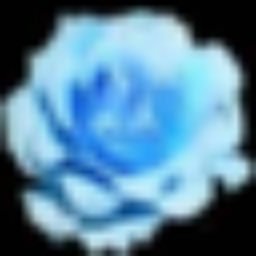

70
nearest images


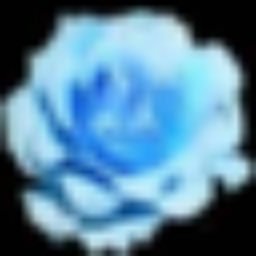

70


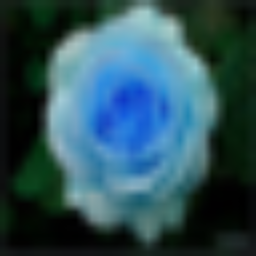

70


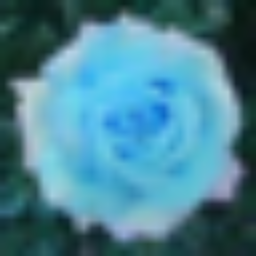

70


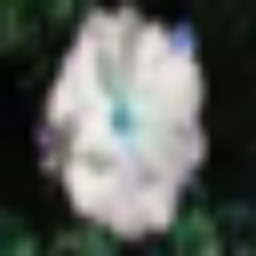

92


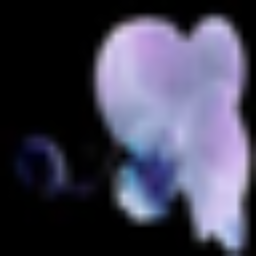

54


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

test_images = test_dataset.data
test_labels = test_dataset.targets

q_ind = 12

test_features = triplet_test_features

sim = np.dot(test_features, test_features.T)
knn_matrix = np.argsort(-sim, axis=1)[:,:5] #top 5

neighbors = knn_matrix[q_ind] # [K]
matched_images = []
matched_labels = []
for neighbor in neighbors:
  matched_images.append(np.asarray(test_images[neighbor]))
  matched_labels.append(np.asarray(test_labels[neighbor]))

print("query image")
cv2_imshow(cv2.resize(test_images[q_ind], (256, 256)))
print(test_labels[q_ind])
print("nearest images")

for i in range(len(matched_images)):
    cv2_imshow(cv2.resize(matched_images[i], (256, 256)))
    print(matched_labels[i])

In [ ]:
from PIL import Image

test_images = test_dataset.data
test_labels = test_dataset.targets



q_ind = 2

test_features = contrastive_test_features

sim = np.dot(test_features, test_features.T)
knn_matrix = np.argsort(-sim, axis=1)[:,:5] #top 5

neighbors = knn_matrix[q_ind] # [K]
matched_images = []
matched_labels = []
for neighbor in neighbors:
  matched_images.append(np.asarray(test_images[neighbor]))
  matched_labels.append(np.asarray(test_labels[neighbor]))

print("query image")
Image.fromarray(test_images[q_ind], 'RGB').resize((256, 256)).show()
print(test_labels[q_ind])
print("nearest images")

for i in range(len(matched_images)):
    Image.fromarray(matched_images[i], 'RGB').resize((256, 256)).show()
    print(matched_labels[i])

query image
71
nearest images
71
71
71
71
71
